In [15]:
"""
===========================================================
Using PyPARRM to filter out stimulation artefacts from data
===========================================================

This example demonstrates how the PARRM algorithm :footcite:`DastinEtAl2021`
can be used to identify and remove stimulation artefacts from
electrophysiological data in the PyPARRM package.
"""

import numpy as np
from matplotlib import pyplot as plt

import sys
import sys
sys.path.append('../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../tool_code/python_tool_code/frequency_dataset_generation/')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT

sys.path.append('../../existing_SAC/PARRM/PyPARRM-main/src/pyparrm/')

from parrm import PARRM
from _utils._power import compute_psd

fpath = "../../evaluation/Test_data/"
# fpath = "../data/synthetic_data/1000_data/"

Contaminated = np.load(fpath + "contaminated_by_realistic" + ".npy")[:10]
Clean = np.load(fpath + "clean_data" + ".npy")[:10]

print(Contaminated.shape)
print(Clean.shape)

(10, 4000)
(10, 4000)


In [16]:
fs = 2000  # Hz
artefact_freq = 125  # Hz

winTime = 0.99
skipTime = winTime / 30
perDist = 0.01

# winTime = 0.5 
# skipTime = winTime / 10  
# perDist = 0.01

winSize = int(fs*winTime)  
skipSize = int(fs*skipTime)
winDir = "both"

print(
    f"`data` has shape: ({Contaminated.shape[0]} channel, "
    f"{Contaminated.shape[1]} timepoints)\n"
    f"`data` duration: {Contaminated.shape[1] / fs :.2f} seconds"
)

`data` has shape: (10 channel, 4000 timepoints)
`data` duration: 2.00 seconds


In [17]:
parrmed = []

for i in range(Contaminated.shape[0]):
    parrm = PARRM(
        data=Contaminated[i].reshape(1, -1),
        sampling_freq=fs,
        artefact_freq=artefact_freq,
        verbose=False,  # silenced to reduce pqdm output clutter
    )

    parrm.find_period()

    print(f"Sample : {i} | Estimated artefact period: {parrm.period :.4f}")

    parrm.create_filter(
        filter_half_width=winSize,
        omit_n_samples=skipSize,
        filter_direction=winDir,
        period_half_width=perDist,
    )
    parrmed_data = parrm.filter_data()  # other data to filter can be given here
    parrmed.append(parrmed_data)


Sample : 0 | Estimated artefact period: 16.0003
Sample : 1 | Estimated artefact period: 17.6008
Sample : 2 | Estimated artefact period: 16.0004
Sample : 3 | Estimated artefact period: 17.6007
Sample : 4 | Estimated artefact period: 16.0004
Sample : 5 | Estimated artefact period: 16.0004
Sample : 6 | Estimated artefact period: 17.6009
Sample : 7 | Estimated artefact period: 16.0003
Sample : 8 | Estimated artefact period: 16.0004
Sample : 9 | Estimated artefact period: 16.0003


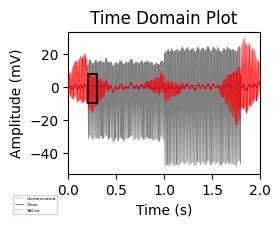

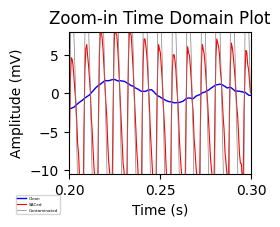

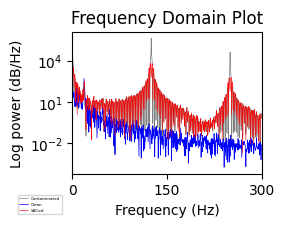

< MSE >
Time Domain MSE: 101.59553209093376 ± 104.95498391352362
Frequency Domain MSE: 83880332.82119797 ± 139771448.39052013
Time + Frequency MSE: 182347.51038185833 ± 342954.0206899559


In [18]:
save_path = '.'
save_title = 'PARRM0'
parrmed = np.array(parrmed)
parrmed = parrmed.reshape(10,-1)

# t = np.arange(0, 2, 1/fs)
# plt.figure()
# plt.plot(t, Contaminated[1].reshape(-1), label='Contaminated', lw = 0.5)
# plt.plot(t, parrmed[1].reshape(-1), label='PARRMed', lw = 0.5)
# plt.plot(t, Clean[1].reshape(-1), label='Clean', lw = 0.5)
# plt.legend()
# plt.show()

# Result_Plot(Contaminated, parrmed, Clean)
Result_Plot_paper(Contaminated, parrmed, Clean, save_path, save_title)

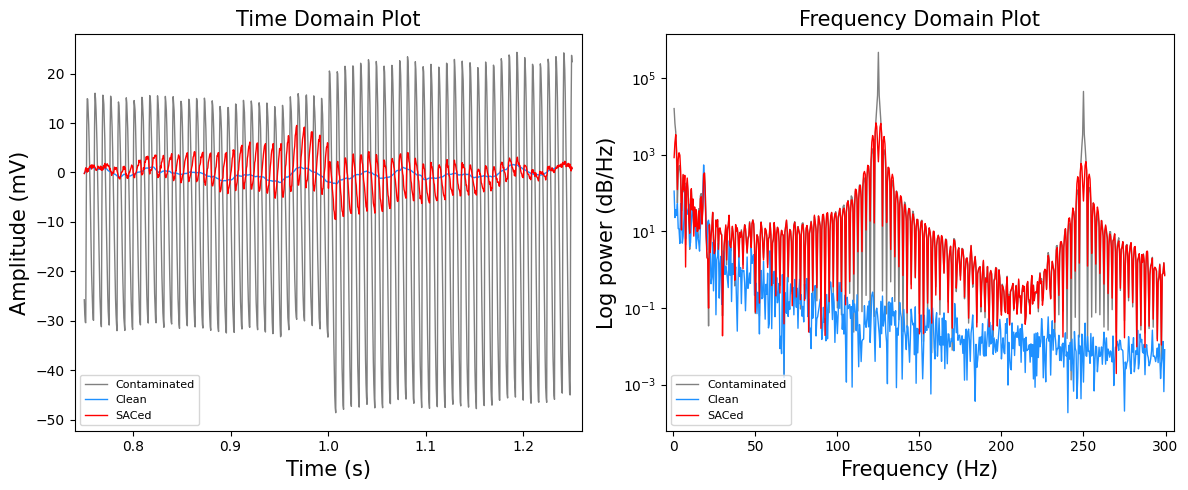

NameError: name 'MSE_std' is not defined

In [23]:
def Result_Plot(Contaminated, SACed, Clean, save_path=None, save_title=None, horizontal=True, small=False):

    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error

    ### Time domain Plotting ###

    t = np.linspace(0, 2, num=4000) 
    start_time = 0.75; # [sec]
    end_time = 1.25; # [sec]
    fs = 2000
    start_pts = int(start_time*fs)
    end_pts = int(end_time*fs)

    if horizontal:
        if small:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))
            #inset_axis = axes[0].inset_axes((0.06, 0.4, 0.3, 0.2))
        else: # large
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
            #inset_axis = axes[0].inset_axes((0.11, 0.27, 0.5, 0.35))
    else: # vertical
        if small:
            fig, axes = plt.subplots(2, 1, figsize=(3, 5))
            #inset_axis = axes[0].inset_axes((0.06, 0.4, 0.3, 0.2))
        else: # large
            fig, axes = plt.subplots(2, 1, figsize=(5, 8))
            #inset_axis = axes[0].inset_axes((0.11, 0.27, 0.5, 0.35))

    # main timeseries plot
    axes[0].plot(t[start_pts:end_pts], Contaminated[0, start_pts:end_pts], label="Contaminated", color="gray", alpha=1, linewidth=1)
    axes[0].plot(t[start_pts:end_pts], Clean[0, start_pts:end_pts], label="Clean", color='dodgerblue', alpha=1, linewidth=1)
    axes[0].plot(t[start_pts:end_pts], SACed[0, start_pts:end_pts], label="SACed", color='red', alpha=1, linewidth=1)
    axes[0].legend(prop={'size': 8}, loc='lower left')
    axes[0].set_xlabel("Time (s)", fontsize=15); axes[0].set_ylabel("Amplitude (mV)", fontsize=15); 
    axes[0].set_xlim(t[start_pts-20], t[end_pts+20])
    axes[0].set_title("Time Domain Plot", fontsize=15)

    # zoom-in(x1) inset plot
    #inset_axis.plot(t[start_pts + 400 : start_pts + 600], Clean[0, start_pts + 400 : start_pts + 600], color='dodgerblue', linewidth=0.9)
    #inset_axis.plot(t[start_pts + 400 : start_pts + 600], SACed[0, start_pts + 400 : start_pts + 600], color='red', linewidth=0.9)
    #axes[0].indicate_inset_zoom(inset_axis, edgecolor="black", alpha=0.8, lw=1.2)
    #inset_axis.plot(t[start_pts + 400 : start_pts + 600], Contaminated[0, start_pts + 400 : start_pts + 600], color='gray', linewidth=0.8)
    #inset_axis.patch.set_alpha(1)
    #inset_axis.set_xlim(t[start_pts + 400-1], t[start_pts + 600])
    #min_val = min(Clean[0, start_pts + 400 : start_pts + 600].min(), SACed[0, start_pts + 400 : start_pts + 600].min())
    #max_val = max(Clean[0, start_pts + 400 : start_pts + 600].max(), SACed[0, start_pts + 400 : start_pts + 600].max())
    #inset_axis.set_ylim(min_val-0.2, max_val+0.2)

    ### Frequency domain Plottig ###  

    freqs, _, _, psd_Contaminated = FFT(Contaminated, fs=2000, single_sided=True)
    _, _, _, psd_Clean = FFT(Clean, fs=2000, single_sided=True)
    _, _, _, psd_SACed = FFT(SACed, fs=2000, single_sided=True)

    axes[1].semilogy(freqs[1:600], psd_Contaminated[0, 1:600], label="Contaminated", color='gray', alpha = 1, linewidth=1)
    axes[1].semilogy(freqs[1:600], psd_Clean[0, 1:600], label="Clean", color='dodgerblue', alpha = 1, linewidth=1)
    axes[1].semilogy(freqs[1:600], psd_SACed[0, 1:600], label="SACed", color='red', alpha = 1, linewidth=1)
    axes[1].legend(prop={'size': 8}, loc='lower left')
    axes[1].set_xlabel("Frequency (Hz)", fontsize=15); axes[1].set_ylabel("Log power (dB/Hz)", fontsize=15)
    axes[1].set_xlim(freqs[1]-5, freqs[600]+5)
    axes[1].set_title("Frequency Domain Plot", fontsize=15)

    fig.tight_layout()

    if save_path != None and save_title != None:
        plt.savefig(save_path + save_title + "_fig" + ".png")# figure를 저장
    plt.show()

    ### MAE / MSE ###
    MSE_std(SACed, Clean, psd_SACed, psd_Clean, save_path, save_title)

Result_Plot(Contaminated, parrmed, Clean)